# Here goes the title
---

Some description.

*Code made by [You](https://github.com/@you) - YYYY.*

### Import required libraries

In [71]:
# IMPORT CONFIGs
import os
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../scripts')
from config import RAW_PATH, TREAT_PATH, OUTPUT_PATH


# DATA ANALYSIS & VIZ TOOLS
from copy import deepcopy

import pandas as pd
pd.options.display.max_columns = 999

import seaborn as sns
import matplotlib.pyplot as pl
import matplotlib.colors as colors 
# Para legenda com linhas:
from matplotlib import lines
# Para legenda com barras:
from matplotlib.patches import Patch

import plotly
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)


# For changes in .py
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [72]:
from utils import *

In [73]:
from other_module import *

# Objetivos

1. Filtrar nomes semi homonimos como 'Tito' e 'Tito da Silva'. 
2. Enumerar tipos de atividade
3. Agrupar tipos de atividade
4. Contar tipos de ativadade nos primeiros 100 dias de cada legislatura
5. Histograma dos parlamentares por atividade + ranking colunar
6. Atividades per capita por partido + Acredito
7. Repetir 5 e 6 para grupos de atividade

# Data

Os dados são consideravelmente grandes, por isso trabalharemos somente com os dados agregados.

In [75]:
raw_df_sample = query_gcp('SELECT * FROM `gabinete-compartilhado.analise_congresso_atividade.tramitacao_por_parlamentar_` LIMIT 100')

In [76]:
raw_df_sample.head(3)

,casa,id,sigla_tipo,numero,ano,data_hora,sequencia,sigla_orgao,uri_orgao,cod_situacao,regime,descricao_tramitacao,cod_tipo_tramitacao,descricao_situacao,despacho,ementa,nome_autor,sigla_partido_autor,sigla_uf_autor,keywords,url,id_parlamentar,nome_parlamentar,sigla_partido,sigla_uf,aday,diff,legislatura,data_displaced
0,camara,2191898,PL,729,2019,2019-03-20 16:05:00,16,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,.,Apresentação de Recurso,192,None,Apresentação do Recurso contra devolução de pr...,"Disciplina a cessão compulsória de órgãos, no ...",Daniel Silveira,PSL,RJ,"alteração, lei de transplantes, cessão compuls...",http://www.camara.gov.br/proposicoesWeb/prop_m...,204454,DANIEL SILVEIRA,PSL,RJ,2019-03-20,0,56,2019-03-20
1,camara,2190174,None,None,None,2019-02-01 18:00:00,2,PLEN,https://dadosabertos.camara.leg.br/api/v2/orga...,None,.,Acessórios,1245,None,PRESIDÊNCIA:Deputado Rodrigo Maia (DEM/RJ): 33...,None,None,None,None,None,None,204506,MARCOS PEREIRA,PRB,SP,2019-02-01,0,56,2019-02-01
2,camara,2190643,RCP,2,2019,2019-04-16 14:30:00,188,CPIBNDES,https://dadosabertos.camara.leg.br/api/v2/orga...,None,.,Aprovação de Requerimento,195,None,Aprovado requerimento do Sr. Sergio Vidigal qu...,Requer a criação de Comissão Parlamentar de In...,Vanderlei Macris,PSDB,SP,None,None,178874,SERGIO VIDIGAL,PDT,ES,2019-04-16,0,56,2019-04-16


In [77]:
raw_df_sample.describe()

,id,sequencia,cod_tipo_tramitacao,id_parlamentar,diff,legislatura
count,1.000000e+02,100.000000,100.000000,100.000000,100.0,100.0
mean,1.982573e+06,73.490000,569.360000,163973.160000,0.0,56.0
std,5.032337e+05,55.564413,456.699855,44885.974266,0.0,0.0
min,1.506900e+04,2.000000,122.000000,73486.000000,0.0,56.0
25%,2.084580e+06,31.250000,195.000000,141553.000000,0.0,56.0
50%,2.190228e+06,57.500000,289.000000,178873.000000,0.0,56.0
75%,2.190658e+06,112.500000,1232.000000,204427.000000,0.0,56.0
max,2.196426e+06,202.000000,1245.000000,204575.000000,0.0,56.0


# Analise

## 1. Filtrar semi homonimos

## 2. Enumerar tipos de atividade

In [78]:
desc_tramitacao = query_gcp(
"""SELECT descricao_tramitacao, count(*) as counta
FROM `gabinete-compartilhado.analise_congresso_atividade.tramitacao_por_parlamentar_` 
GROUP BY descricao_tramitacao
ORDER BY counta DESC""")

In [79]:
desc_tramitacao

,descricao_tramitacao,counta
0,Apresentação de Proposição,6330
1,Apresentação de Requerimento,4779
2,Designação de Relator,3118
3,Aprovação de Proposição Interna,941
4,Saída de Relator da Comissão - Sem Parecer Apr...,896
5,Saída de Relator da Comissão - Com Parecer Apr...,891
6,Parecer do Relator,823
7,Recebimento - Relator,717
8,Distribuição,656
9,Discussão da Materia pelos Deputados,636


### Atividades interessantes:
- Relatorias 
- Parecer de Relatoria
- Apresentação de Proposição grande (PL, PEC, PLC) 

## 5. Parlamentares por atividade

### Numero de parlamentares por partido

In [80]:
partido_bancada = query_gcp("""
SELECT sigla_partido, count(*) as numero_parlamentares
FROM `gabinete-compartilhado.congresso.camara_deputado_` 
WHERE ultima_legislatura = 56
GROUP BY sigla_partido
""")

In [81]:
partido_bancada = (pd.concat([partido_bancada, 
                             pd.DataFrame([{'sigla_partido': 'Acredito', 'numero_parlamentares': 2}])])
                .reset_index(drop=True))

In [82]:
partido_bancada.head(3)

,numero_parlamentares,sigla_partido
0,9,PCdoB
1,39,PSD
2,30,PSDB


In [83]:
deputados = query_gcp("""
SELECT nome_parlamentar
FROM `gabinete-compartilhado.congresso.camara_deputado_` 
WHERE ultima_legislatura = 56
""")

### Aggregate query

In [100]:
atividades = {
    'relatorias': "descricao_tramitacao = 'Designação de Relator' AND sigla_tipo IN ('PL', 'PEC', 'MPV', 'PLC')",
    'pareceres de relatoria': "(descricao_tramitacao = 'Parecer do Relator') AND sigla_tipo IN ('PL', 'PEC', 'MPV', 'PLC')",
    'requerimentos de informação': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'RIC'",
    'obstruções em plenário': "descricao_tramitacao = 'Obstrução Discussão (Plenário)'",
    'discussões de matéria': "(descricao_tramitacao = 'Discussão da Materia pelos Deputados' OR lower(despacho) like '%discutiu a matéria%')",
    'aprovações de requerimento': "descricao_tramitacao = 'Aprovação de Requerimento'",
    'apresentações de requerimento': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'REQ'",
    #'apresentações de PDL': "descricao_tramitacao = 'Apresentação de Proposição' AND sigla_tipo = 'PDL'"
}

---------------
relatorias
---------------
Deputados
Posicao Tabata 35
Posicao Rigoni 24


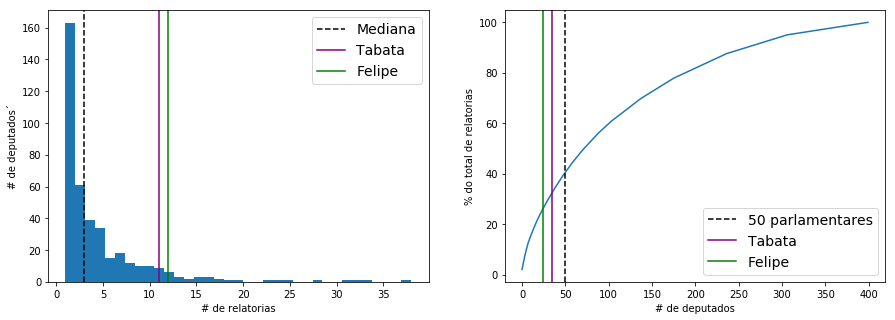

---------------
Partidos


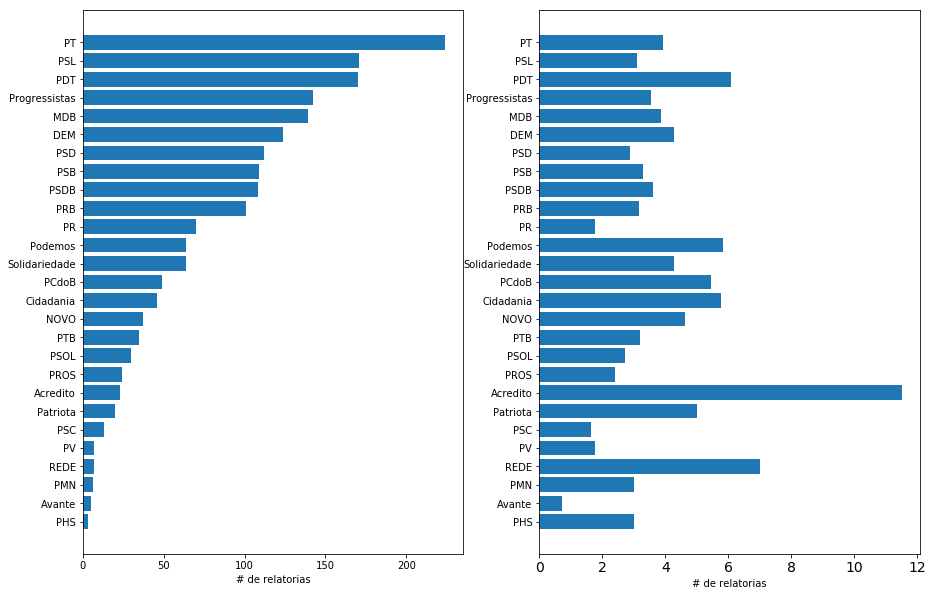

---------------
pareceres de relatoria
---------------
Deputados
Posicao Rigoni 10


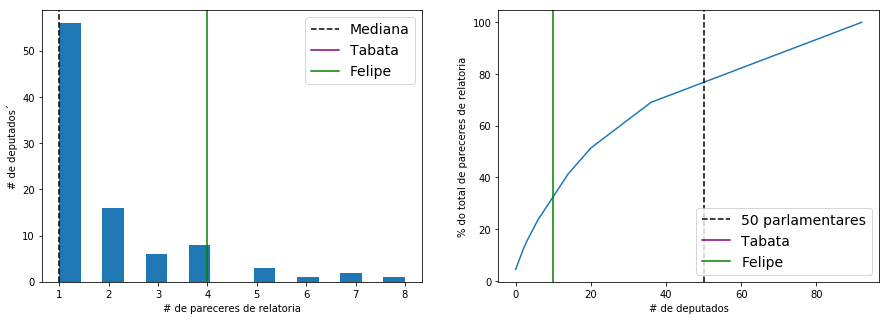

---------------
Partidos


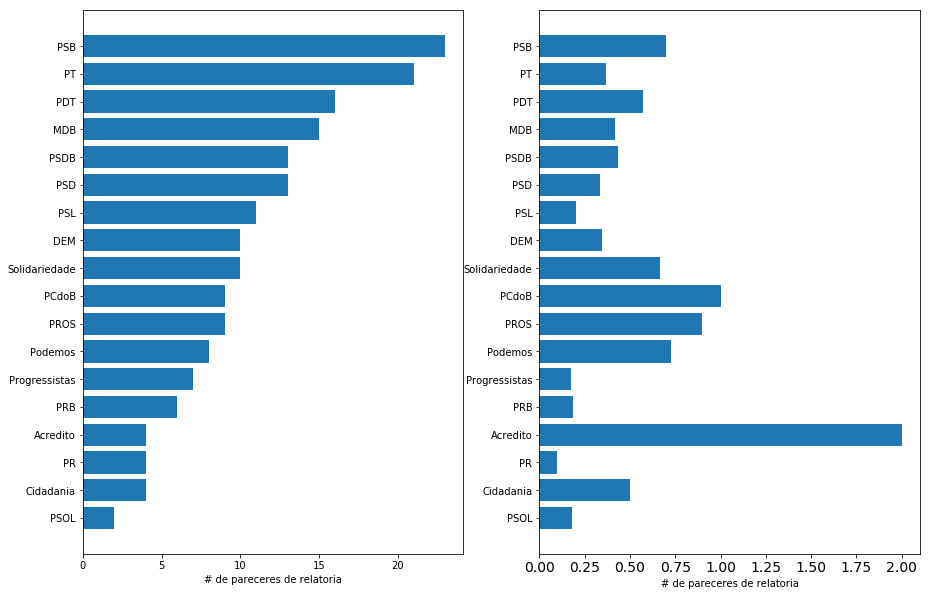

---------------
requerimentos de informação
---------------
Deputados
Posicao Tabata 42
Posicao Rigoni 132


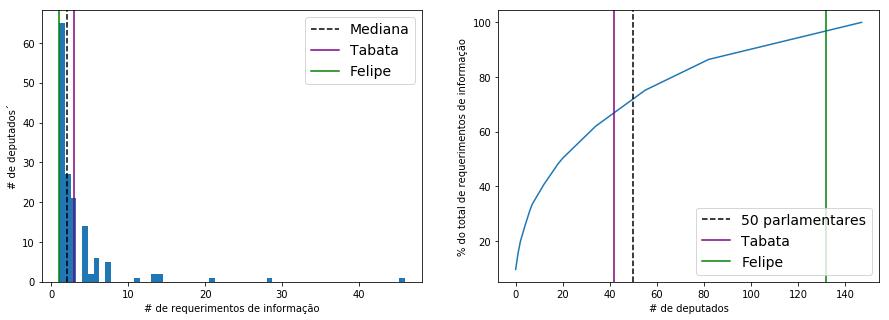

---------------
Partidos


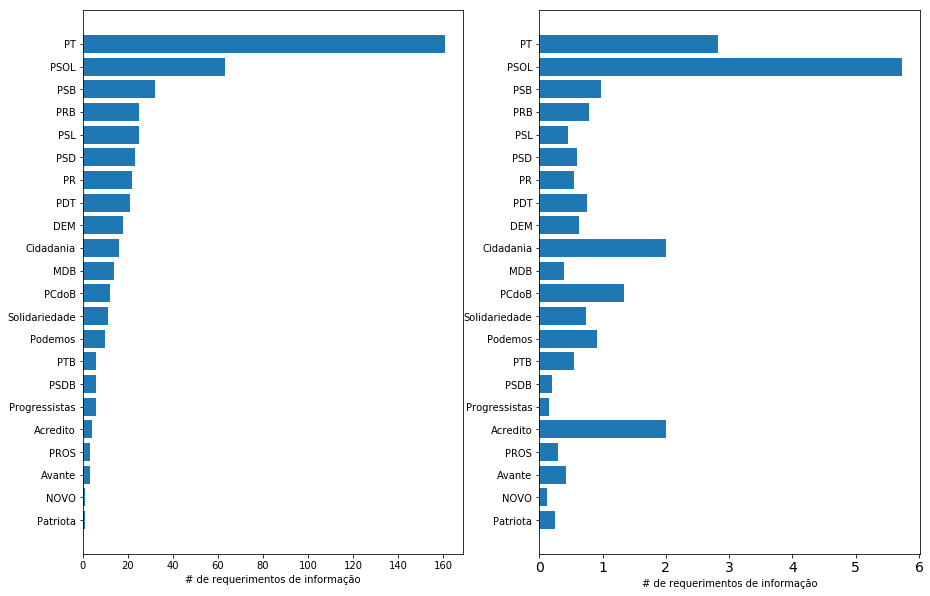

---------------
obstruções em plenário
---------------
Deputados


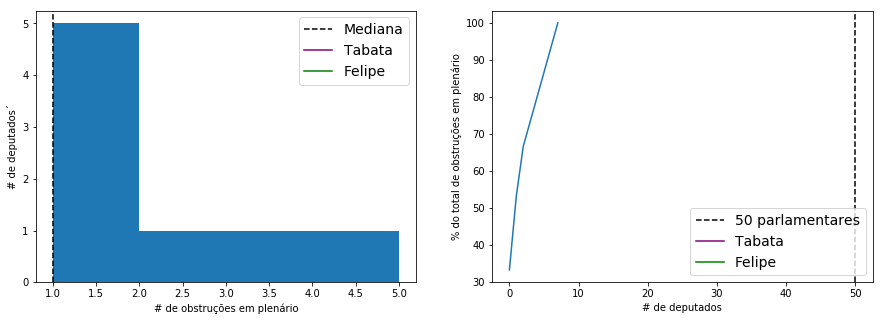

---------------
Partidos


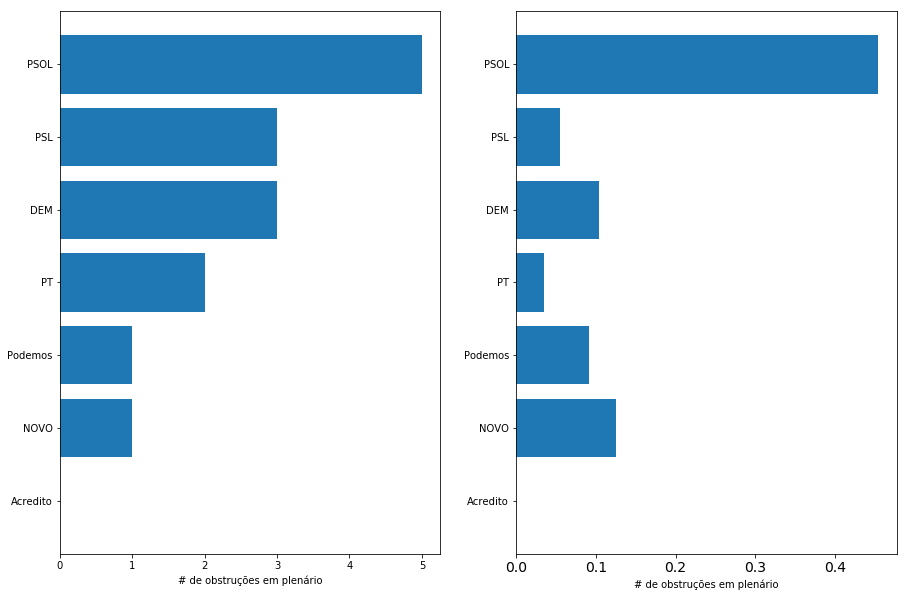

---------------
discussões de matéria
---------------
Deputados
Posicao Tabata 191
Posicao Rigoni 173


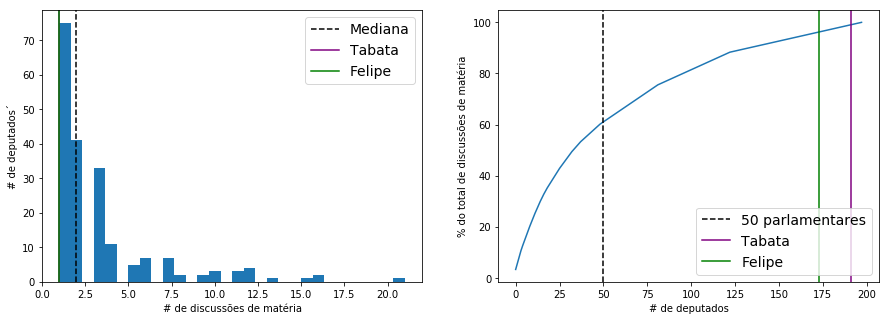

---------------
Partidos


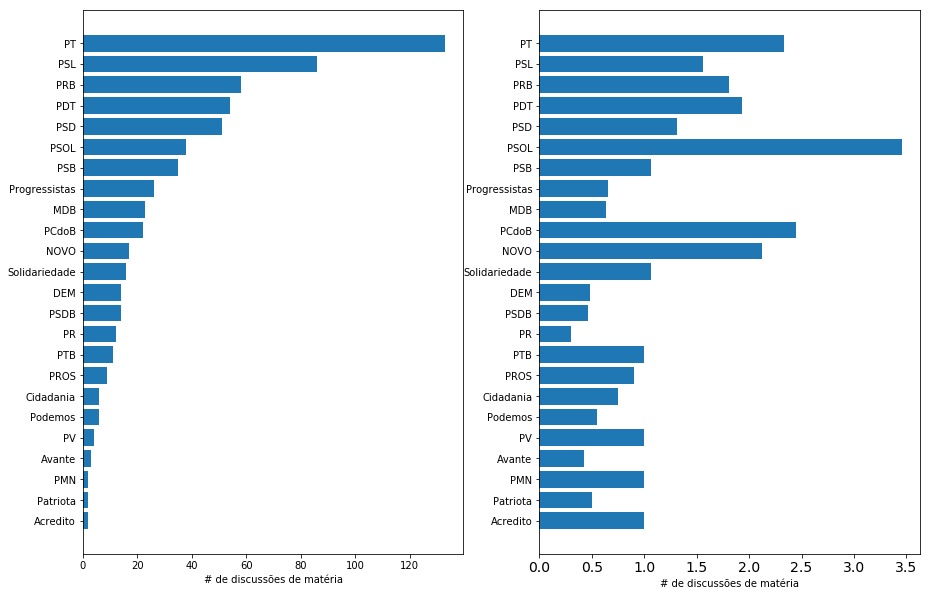

---------------
aprovações de requerimento
---------------
Deputados


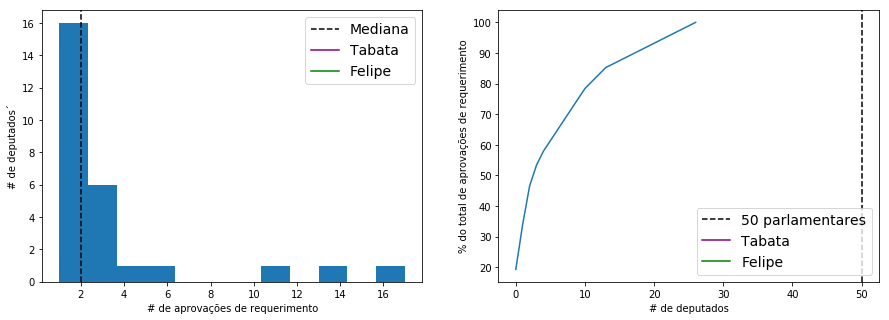

---------------
Partidos


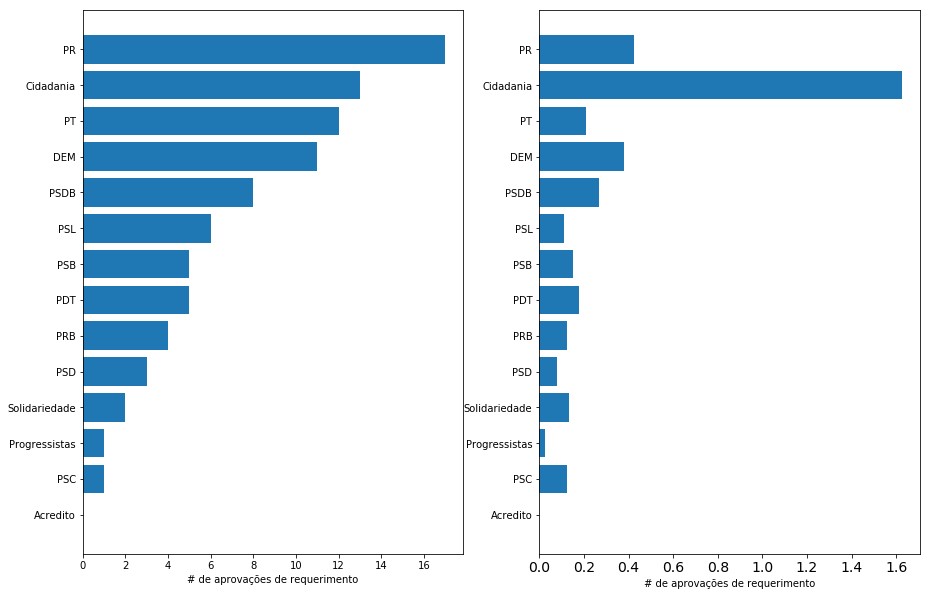

---------------
apresentações de requerimento
---------------
Deputados
Posicao Tabata 205
Posicao Rigoni 201


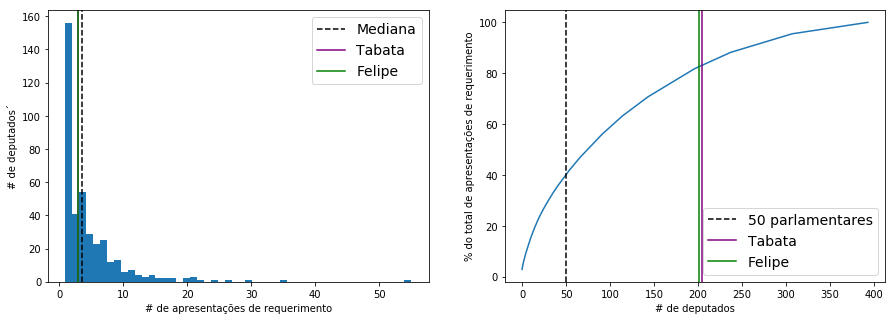

---------------
Partidos


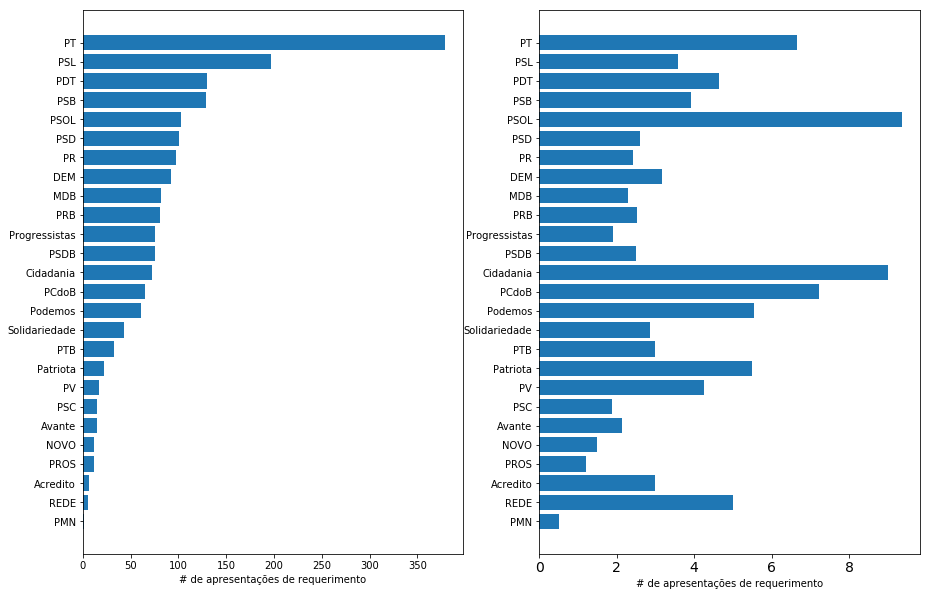

In [101]:
for acao in atividades.keys():
    build_plots(atividades, acao, partido_bancada)

In [94]:
final = pd.DataFrame()
for f in OUTPUT_PATH.glob('*_deputados.csv'):
    file = pd.read_csv(f)
    print(f.name.split('_')[0])
    file['acao'] = f.name.split('_')[0]
    final = pd.concat([final, file])

obstruções em plenário
apresentações de requerimento
aprovações de requerimento
pareceres de relatoria
requerimentos de informação
aprovações de requerimentos
discussões de matéria
apresentações de PDL
relatorias
discussões da matéria


In [95]:
final.head(1)

,Unnamed: 0,legislatura,nome_parlamentar,sigla_partido,acoes,acao
0,2,56,BACELAR,Podemos,1,obstruções em plenário


In [96]:
deputados_atividade = final.drop_duplicates(subset=['nome_parlamentar', 'acoes', 'acao']).pivot(index='nome_parlamentar', columns='acao', values='acoes').fillna(0)


In [97]:
deputados_atividade = deputados_atividade.merge(deputados, left_index=True, right_on='nome_parlamentar', how='right')\
.set_index('nome_parlamentar')


In [98]:
deputados_atividade.sum(1).sort_values(ascending=False)

nome_parlamentar
ERIKA KOKAY               146.0
KIM KATAGUIRI              85.0
FLÁVIA MORAIS              77.0
IVAN VALENTE               74.0
PAULA BELMONTE             73.0
MARGARIDA SALOMÃO          58.0
ALTINEU CÔRTES             56.0
HILDO ROCHA                54.0
EDUARDO BARBOSA            52.0
BIBO NUNES                 50.0
DIEGO GARCIA               49.0
PAULO GUEDES               49.0
PERPÉTUA ALMEIDA           49.0
SÂMIA BOMFIM               48.0
POMPEO DE MATTOS           46.0
ROGÉRIO CORREIA            45.0
JÚLIO CESAR                44.0
ALCEU MOREIRA              43.0
ALICE PORTUGAL             43.0
CARMEN ZANOTTO             43.0
NILTO TATTO                43.0
JOÃO DANIEL                42.0
MARIA DO ROSÁRIO           39.0
PAULO TEIXEIRA             38.0
ROBERTO ALVES              37.0
JOSÉ RICARDO               37.0
LUIZ LIMA                  36.0
ASSIS CARVALHO             35.0
ALEXANDRE PADILHA          33.0
MÁRCIO JERRY               33.0
                       

In [99]:
deputados_atividade[deputados_atividade.index.str.contains('NEVES')]

,apresentações de PDL,apresentações de requerimento,aprovações de requerimento,aprovações de requerimentos,discussões da matéria,discussões de matéria,obstruções em plenário,pareceres de relatoria,relatorias,requerimentos de informação
nome_parlamentar,,,,,,,,,,
